In [122]:
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from collections import Counter
from scipy.special import expit
import math
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
from sqlalchemy import create_engine

# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = 'Nkbr1998'
POSTGRES_DBNAME = 'COVID19-DB'

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

# Create the connection
cnx = create_engine(postgres_str)

In [2]:
# Load the data
file_path = Path('covid_cleaned.csv')
df = pd.read_csv(file_path)
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,4/5/2020,5/2/2020,NaN,NaN,2.0,27.0,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,NaN
1,1009bf,2,1,3/19/2020,3/17/2020,NaN,NaN,2.0,24.0,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,NaN
2,167386,1,2,6/4/2020,4/1/2020,NaN,2.0,2.0,54.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN,1,2.0
3,0b5948,2,2,4/17/2020,4/10/2020,NaN,2.0,1.0,30.0,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,2.0
4,0d01b5,1,2,4/13/2020,4/13/2020,4/22/2020,2.0,2.0,60.0,2.0,...,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN,1,2.0


In [3]:
#Dropping date_died since a very small population died. 
#Dropping pregnancy so that when dropping NAN the entire population is not female.
df = df.drop(columns=['date_died', 'pregnancy', 'id'])
df.head()

,sex,patient_type,entry_date,date_symptoms,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,2,1,4/5/2020,5/2/2020,NaN,2.0,27.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,NaN
1,2,1,3/19/2020,3/17/2020,NaN,2.0,24.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,NaN
2,1,2,6/4/2020,4/1/2020,2.0,2.0,54.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN,1,2.0
3,2,2,4/17/2020,4/10/2020,2.0,1.0,30.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,2.0
4,1,2,4/13/2020,4/13/2020,2.0,2.0,60.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN,1,2.0


In [4]:
df = df.dropna()
df.head()

,sex,patient_type,entry_date,date_symptoms,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
21,1,2,2/6/2020,6/2/2020,2.0,2.0,25.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0
30,1,2,6/22/2020,6/17/2020,2.0,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0
50,2,2,12/4/2020,4/7/2020,1.0,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0
71,1,2,6/17/2020,6/12/2020,2.0,1.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0
79,1,2,8/6/2020,6/7/2020,1.0,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0


In [5]:
df.describe()
df.dtypes

sex                      int64
patient_type             int64
entry_date              object
date_symptoms           object
intubed                float64
pneumonia              float64
age                    float64
diabetes               float64
copd                   float64
asthma                 float64
inmsupr                float64
hypertension           float64
other_disease          float64
cardiovascular         float64
obesity                float64
renal_chronic          float64
tobacco                float64
contact_other_covid    float64
covid_res                int64
icu                    float64
dtype: object

In [6]:
df = df.astype({'entry_date': 'datetime64'})

In [7]:
df = df.astype({'date_symptoms': 'datetime64'})

In [8]:
df.dtypes

sex                             int64
patient_type                    int64
entry_date             datetime64[ns]
date_symptoms          datetime64[ns]
intubed                       float64
pneumonia                     float64
age                           float64
diabetes                      float64
copd                          float64
asthma                        float64
inmsupr                       float64
hypertension                  float64
other_disease                 float64
cardiovascular                float64
obesity                       float64
renal_chronic                 float64
tobacco                       float64
contact_other_covid           float64
covid_res                       int64
icu                           float64
dtype: object

In [9]:
df["entry_date_minus_date_symptoms"] = df["entry_date"] - df["date_symptoms"]
df.head()

,sex,patient_type,entry_date,date_symptoms,intubed,pneumonia,age,diabetes,copd,asthma,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms
21,1,2,2020-02-06,2020-06-02,2.0,2.0,25.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,-117 days
30,1,2,2020-06-22,2020-06-17,2.0,2.0,52.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,5 days
50,2,2,2020-12-04,2020-04-07,1.0,1.0,57.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,241 days
71,1,2,2020-06-17,2020-06-12,2.0,1.0,51.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,5 days
79,1,2,2020-08-06,2020-06-07,1.0,1.0,67.0,1.0,2.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,60 days


In [10]:
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,sex,patient_type,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms
21,1,2,2.0,2.0,25.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,-117 days
30,1,2,2.0,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,5 days
50,2,2,1.0,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,241 days
71,1,2,2.0,1.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,5 days
79,1,2,1.0,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,60 days


In [11]:
df = df[df["entry_date_minus_date_symptoms"] >= '0 days']
df.head()

,sex,patient_type,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms
30,1,2,2.0,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,5 days
50,2,2,1.0,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,241 days
71,1,2,2.0,1.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,5 days
79,1,2,1.0,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,60 days
93,1,2,2.0,1.0,59.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,0 days


In [12]:
df = df.astype({'entry_date_minus_date_symptoms': 'int64'})
df.head()

,sex,patient_type,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms
30,1,2,2.0,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,432000000000000
50,2,2,1.0,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,20822400000000000
71,1,2,2.0,1.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,432000000000000
79,1,2,1.0,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,5184000000000000
93,1,2,2.0,1.0,59.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,0


In [13]:
df["entry_date_minus_date_symptoms"] = df["entry_date_minus_date_symptoms"]/86400000000000

In [14]:
pneumonia = df['pneumonia']

In [15]:
df = df.drop(columns=['pneumonia'])

In [16]:
df['pneumonia'] = pneumonia

In [17]:
df.head(5)

,sex,patient_type,intubed,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms,pneumonia
30,1,2,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,5.0,2.0
50,2,2,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,241.0,1.0
71,1,2,2.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,5.0,1.0
79,1,2,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,60.0,1.0
93,1,2,2.0,59.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,0.0,1.0


In [18]:
df.to_csv('covid_08_04_2020.csv')

In [19]:
df.dtypes

sex                                 int64
patient_type                        int64
intubed                           float64
age                               float64
diabetes                          float64
copd                              float64
asthma                            float64
inmsupr                           float64
hypertension                      float64
other_disease                     float64
cardiovascular                    float64
obesity                           float64
renal_chronic                     float64
tobacco                           float64
contact_other_covid               float64
covid_res                           int64
icu                               float64
entry_date_minus_date_symptoms    float64
pneumonia                         float64
dtype: object

In [20]:
df["pneumonia"].value_counts()

1.0    35505
2.0    15869
Name: pneumonia, dtype: int64

In [29]:
# Compare Algorithms
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [30]:
# load dataset
array = df.values
array

array([[  1.,   2.,   2., ...,   2.,   5.,   2.],
       [  2.,   2.,   1., ...,   2., 241.,   1.],
       [  1.,   2.,   2., ...,   2.,   5.,   1.],
       ...,
       [  2.,   2.,   2., ...,   2.,   0.,   1.],
       [  2.,   2.,   1., ...,   1.,  43.,   1.],
       [  2.,   2.,   1., ...,   1.,  89.,   1.]])

In [31]:
X = array[:,0:18]
Y = array[:,18]
# prepare configuration for cross validation test harness
seed = 0
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [32]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.714618 (0.062625)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/pyt

LDA: 0.713819 (0.063947)
KNN: 0.680905 (0.051554)
CART: 0.644077 (0.047336)
NB: 0.597285 (0.030568)


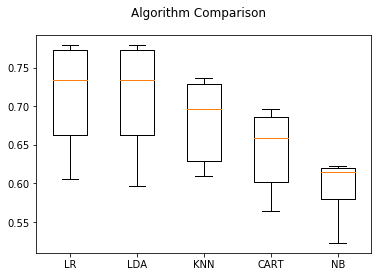

In [33]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [35]:
df_no_x = df.drop(columns="pneumonia")
df_no_x

,sex,patient_type,intubed,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,entry_date_minus_date_symptoms
30,1,2,2.0,52.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1,2.0,5.0
50,2,2,1.0,57.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1,2.0,241.0
71,1,2,2.0,51.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,5.0
79,1,2,1.0,67.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1,2.0,60.0
93,1,2,2.0,59.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566552,2,2,1.0,59.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3,1.0,187.0
566559,1,2,2.0,17.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,5.0
566565,2,2,2.0,68.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,3,2.0,0.0
566590,2,2,1.0,68.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,3,1.0,43.0


In [159]:
# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_no_x, df["pneumonia"], random_state=0)

In [160]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [161]:
fit = logisticRegr.fit(X_train, y_train)

In [162]:
predictions = logisticRegr.predict(X_test)
predictions_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test})
predictions_df = predictions_df.replace(1, 0)

In [169]:
predictions_df = predictions_df.replace(2, 1)
prediction_array = predictions_df["Prediction"].values
actual_array = predictions_df["Actual"].values

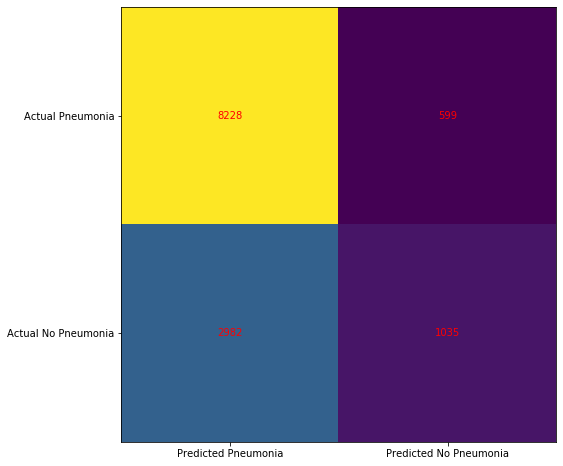

In [170]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Pneumonia', 'Predicted No Pneumonia'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Pneumonia', 'Actual No Pneumonia'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [171]:
print(classification_report(actual_array, prediction_array))

              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82      8827
         1.0       0.63      0.26      0.37      4017

    accuracy                           0.72     12844
   macro avg       0.68      0.59      0.59     12844
weighted avg       0.70      0.72      0.68     12844



In [172]:
from sklearn.metrics import accuracy_score
accuracy_score(actual_array, prediction_array)

0.7211927748364996

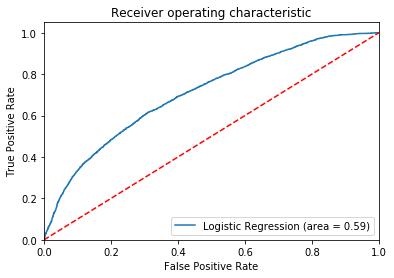

In [173]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(actual_array, prediction_array)
fpr, tpr, thresholds = roc_curve(actual_array, logisticRegr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [174]:
logisticRegr.predict_proba(X_test)[:,1]

array([0.55617434, 0.56045435, 0.20990181, ..., 0.24666675, 0.43945176,
       0.04754097])